In [1]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.fft
import time

from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
#formatting plot style
from matplotlib import rc
font = {'family': 'serif',
        'serif': ['Computer Modern'],
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}'
                          r'\boldmath')

In [3]:
#creating new colormap
top = cm.get_cmap('PuRd_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='custom')

In [4]:
#v_fourier outputs the expression for the velocity field in Fourier space, 
#which is computed with a Mathematica notebook
def v_fourier(Q, qx, qy, qz, eps, F, visc_coeff):
    
    #create grid in Fourier space
    qxg, qyg, qzg = np.meshgrid(qx, qy, qz) 
    
    qsqr = qxg**2 + qyg**2 + qzg**2
    q = np.array([qxg, qyg, qzg])
    
    #will regularize integrand with Gaussian kernel to avoid Gibbs oscillations
    a = np.pi / (2*Q)
    gauss = np.exp(-a**2 * qsqr / np.pi)
    
    #all viscosity coefficients
    etaR1, etaR2, etaRo= visc_coeff[0], visc_coeff[1], visc_coeff[2]
    etaeQ1, etaoQ1 = visc_coeff[3], visc_coeff[4]
    etaeQ2, etaoQ2 = visc_coeff[5], visc_coeff[6]
    etaeQ3, etaoQ3 = visc_coeff[7], visc_coeff[8]
    etaeA, etaoA = visc_coeff[9], visc_coeff[10]
    etaeS, etaoS = visc_coeff[11], visc_coeff[12]
    xi = visc_coeff[13]
    etao1, etao2 = visc_coeff[14], visc_coeff[15]
    mu = visc_coeff[16]
    
    #expression for velocity field in Fourier space from Mathematica calculation
    denom1 = ( ( mu )**( 2 ) * ( qxg )**( 6 ) + ( 3 * ( mu )**( 2 ) * ( qxg )**( 4 ) * ( qyg )**( 2 ) + ( 3 * ( mu )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 4 ) + ( ( mu )**( 2 ) * ( qyg )**( 6 ) + ( -3 * ( etaeQ3 )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( ( etao1 )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao1 * etao2 * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( ( etao2 )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etao1 * etaoQ3 * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etao2 * etaoQ3 * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 3 * ( etaoQ3 )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao1 * etaRo * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 3 * ( mu )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( -6 * ( etaeQ3 )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 2 * ( etao1 )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 4 * etao1 * etao2 * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 2 * ( etao2 )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( -4 * ( 3 )**( 1/2 ) * etao1 * etaoQ3 * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( -4 * ( 3 )**( 1/2 ) * etao2 * etaoQ3 * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 6 * ( etaoQ3 )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 6 * ( mu )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( -3 * ( etaeQ3 )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( ( etao1 )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao1 * etao2 * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( ( etao2 )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etao1 * etaoQ3 * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etao2 * etaoQ3 * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 3 * ( etaoQ3 )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 3 * ( mu )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( -4 * ( etaeQ2 )**( 2 ) * ( ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) )**( 2 ) * ( qzg )**( 2 ) + ( 4 * ( 3 )**( 1/2 ) * etaeQ2 * etaeQ3 * ( ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) )**( 2 ) * ( qzg )**( 2 ) + ( -2 * etao1 * etao2 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -2 * ( etao2 )**( 2 ) * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etao1 * etaoQ2 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etao2 * etaoQ2 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * ( 3 )**( 1/2 ) * etao2 * etaoQ3 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 4 * ( 3 )**( 1/2 ) * etaoQ2 * etaoQ3 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 3 * ( mu )**( 2 ) * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -2 * etao1 * etao2 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( -2 * ( etao2 )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etao1 * etaoQ2 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etao2 * etaoQ2 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * ( 3 )**( 1/2 ) * etao2 * etaoQ3 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 4 * ( 3 )**( 1/2 ) * etaoQ2 * etaoQ3 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 3 * ( mu )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( ( etao2 )**( 2 ) * ( qzg )**( 6 ) + ( 4 * etao2 * etaoQ2 * ( qzg )**( 6 ) + ( 4 * ( etaoQ2 )**( 2 ) * ( qzg )**( 6 ) + ( ( mu )**( 2 ) * ( qzg )**( 6 ) + -4 * ( etaeQ1 )**( 2 ) * ( qzg )**( 2 ) * ( ( qxg )**( 4 ) + ( 2 * ( qxg )**( 2 ) * ( qyg )**( 2 ) + ( ( qyg )**( 4 ) + -1 * ( qzg )**( 4 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
    denom2 = ( etaR1 * etaR2 * ( qxg )**( 6 ) + ( etaR1 * mu * ( qxg )**( 6 ) + ( etaR2 * mu * ( qxg )**( 6 ) + ( 3 * etaR1 * etaR2 * ( qxg )**( 4 ) * ( qyg )**( 2 ) + ( 3 * etaR1 * mu * ( qxg )**( 4 ) * ( qyg )**( 2 ) + ( 3 * etaR2 * mu * ( qxg )**( 4 ) * ( qyg )**( 2 ) + ( 3 * etaR1 * etaR2 * ( qxg )**( 2 ) * ( qyg )**( 4 ) + ( 3 * etaR1 * mu * ( qxg )**( 2 ) * ( qyg )**( 4 ) + ( 3 * etaR2 * mu * ( qxg )**( 2 ) * ( qyg )**( 4 ) + ( etaR1 * etaR2 * ( qyg )**( 6 ) + ( etaR1 * mu * ( qyg )**( 6 ) + ( etaR2 * mu * ( qyg )**( 6 ) + ( ( etaR1 )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etaR1 * etaR2 * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao2 * etaRo * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etaoQ3 * etaRo * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( ( etaRo )**( 2 ) * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 4 * etaR1 * mu * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etaR2 * mu * ( qxg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * ( etaR1 )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 4 * etaR1 * etaR2 * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 4 * etao1 * etaRo * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 4 * etao2 * etaRo * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( -4 * ( 3 )**( 1/2 ) * etaoQ3 * etaRo * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 2 * ( etaRo )**( 2 ) * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 8 * etaR1 * mu * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( 4 * etaR2 * mu * ( qxg )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( ( etaR1 )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etaR1 * etaR2 * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao1 * etaRo * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etao2 * etaRo * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( -2 * ( 3 )**( 1/2 ) * etaoQ3 * etaRo * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( ( etaRo )**( 2 ) * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 4 * etaR1 * mu * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * etaR2 * mu * ( qyg )**( 4 ) * ( qzg )**( 2 ) + ( 2 * ( etaR1 )**( 2 ) * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( etaR1 * etaR2 * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * etao1 * etaRo * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etaoQ2 * etaRo * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( -2 * ( 3 )**( 1/2 ) * etaoQ3 * etaRo * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * ( etaRo )**( 2 ) * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 5 * etaR1 * mu * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( etaR2 * mu * ( qxg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * ( etaR1 )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( etaR1 * etaR2 * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * etao1 * etaRo * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( -4 * etaoQ2 * etaRo * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( -2 * ( 3 )**( 1/2 ) * etaoQ3 * etaRo * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 2 * ( etaRo )**( 2 ) * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( 5 * etaR1 * mu * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( etaR2 * mu * ( qyg )**( 2 ) * ( qzg )**( 4 ) + ( ( etaR1 )**( 2 ) * ( qzg )**( 6 ) + ( -2 * etao2 * etaRo * ( qzg )**( 6 ) + ( -4 * etaoQ2 * etaRo * ( qzg )**( 6 ) + ( ( etaRo )**( 2 ) * ( qzg )**( 6 ) + ( 2 * etaR1 * mu * ( qzg )**( 6 ) + -2 * etaeQ1 * ( ( qxg )**( 2 ) + ( ( qyg )**( 2 ) + ( qzg )**( 2 ) ) ) * ( -2 * etaR1 * ( qzg )**( 4 ) + ( etaR2 * ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) * ( ( qxg )**( 2 ) + ( ( qyg )**( 2 ) + -1 * ( qzg )**( 2 ) ) ) + mu * ( ( qxg )**( 4 ) + ( ( qyg )**( 4 ) + ( -1 * ( qyg )**( 2 ) * ( qzg )**( 2 ) + ( -2 * ( qzg )**( 4 ) + ( qxg )**( 2 ) * ( 2 * ( qyg )**( 2 ) + -1 * ( qzg )**( 2 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
    
    vfx_num = F[2] * qzg * ( etaR2 * ( qxg )**( 3 ) + ( mu * ( qxg )**( 3 ) + ( ( 3 )**( 1/2 ) * etaeQ3 * ( qxg )**( 2 ) * qyg + ( -1 * etao1 * ( qxg )**( 2 ) * qyg + ( -1 * etao2 * ( qxg )**( 2 ) * qyg + ( ( 3 )**( 1/2 ) * etaoQ3 * ( qxg )**( 2 ) * qyg + ( -1 * etaRo * ( qxg )**( 2 ) * qyg + ( etaR2 * qxg * ( qyg )**( 2 ) + ( mu * qxg * ( qyg )**( 2 ) + ( ( 3 )**( 1/2 ) * etaeQ3 * ( qyg )**( 3 ) + ( -1 * etao1 * ( qyg )**( 3 ) + ( -1 * etao2 * ( qyg )**( 3 ) + ( ( 3 )**( 1/2 ) * etaoQ3 * ( qyg )**( 3 ) + ( -1 * etaRo * ( qyg )**( 3 ) + ( -2 * etaeQ2 * qyg * ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) + ( 2 * etaeQ1 * qxg * ( qzg )**( 2 ) + ( etaR1 * qxg * ( qzg )**( 2 ) + ( mu * qxg * ( qzg )**( 2 ) + ( etao2 * qyg * ( qzg )**( 2 ) + ( 2 * etaoQ2 * qyg * ( qzg )**( 2 ) + -1 * etaRo * qyg * ( qzg )**( 2 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
    vfy_num = F[2] * qzg * ( -1 * ( 3 )**( 1/2 ) * etaeQ3 * ( qxg )**( 3 ) + ( etao1 * ( qxg )**( 3 ) + ( etao2 * ( qxg )**( 3 ) + ( -1 * ( 3 )**( 1/2 ) * etaoQ3 * ( qxg )**( 3 ) + ( etaRo * ( qxg )**( 3 ) + ( etaR2 * ( qxg )**( 2 ) * qyg + ( mu * ( qxg )**( 2 ) * qyg + ( -1 * ( 3 )**( 1/2 ) * etaeQ3 * qxg * ( qyg )**( 2 ) + ( etao1 * qxg * ( qyg )**( 2 ) + ( etao2 * qxg * ( qyg )**( 2 ) + ( -1 * ( 3 )**( 1/2 ) * etaoQ3 * qxg * ( qyg )**( 2 ) + ( etaRo * qxg * ( qyg )**( 2 ) + ( etaR2 * ( qyg )**( 3 ) + ( mu * ( qyg )**( 3 ) + ( 2 * etaeQ2 * qxg * ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) + ( -1 * etao2 * qxg * ( qzg )**( 2 ) + ( -2 * etaoQ2 * qxg * ( qzg )**( 2 ) + ( etaRo * qxg * ( qzg )**( 2 ) + ( 2 * etaeQ1 * qyg * ( qzg )**( 2 ) + ( etaR1 * qyg * ( qzg )**( 2 ) + mu * qyg * ( qzg )**( 2 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
    vfz_num = -1 * F[2] * ( ( qxg )**( 2 ) + ( qyg )**( 2 ) ) * ( etaR2 * ( qxg )**( 2 ) + ( mu * ( qxg )**( 2 ) + ( etaR2 * ( qyg )**( 2 ) + ( mu * ( qyg )**( 2 ) + ( 2 * etaeQ1 * ( qzg )**( 2 ) + ( etaR1 * ( qzg )**( 2 ) + mu * ( qzg )**( 2 ) ) ) ) ) ) )
    
    #add epsilon^2 to denominator of integrand to regularize at q = 0
    vfx = gauss*vfx_num / (denom1 + denom2 + eps**2) 
    vfy = gauss*vfy_num / (denom1 + denom2 + eps**2)
    vfz = gauss*vfz_num / (denom1 + denom2 + eps**2)
        
    return [vfx, vfy, vfz]

In [5]:
#v_fourier_ifft performs the numerical inversion to compute the real space velocity field
def v_fourier_ifft(Q, dq, eps, visc_coeff, F):
    
    #set up grid in Fourier space, ranging from -Q to Q with spacing dq
    xs = scipy.fft.fftfreq(len(np.arange(-Q, Q+dq, dq)), dq/(2*np.pi))
    qs = scipy.fft.ifftshift(np.linspace(-Q, Q, len(xs)))
    
    #compute Fourier space velocity field on this grid using analytical expression
    vf = v_fourier(Q, qs, qs, qs, eps, F, visc_coeff)
    
    #invert
    v = []
    for i in range(3):
        vi = 1 / (2*np.pi)**3 * (2*Q)**3 * scipy.fft.irfftn(vf[i], s = [len(xs), len(xs), len(xs)], workers = 3)
        
        v.append(scipy.fft.fftshift(vi))
    
    return scipy.fft.fftshift(xs), v

## example: comparison with standard Stokeslet

In [6]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
etaeQ1, etaoQ1 = 0, 0
etaeQ2, etaoQ2 = 0, 0
etaeQ3, etaoQ3 = 0, 0
etaeA, etaoA = 0, 0
etaeS, etaoS = 0, 0
xi = 0
etao1, etao2 = 0, 0
mu = 1

visc_coeff_list = [etaR1, etaR2, etaRo, etaeQ1, etaoQ1, etaeQ2, etaoQ2, etaeQ3, etaoQ3, etaeA,
                  etaoA, etaeS, etaoS, xi, etao1, etao2, mu]

#call inverse FFT function
fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

#compute velocities in cylindrical coordinates from v (Cartesian coordinates)
x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)
vr = (v[0]*x + v[1]*y) / np.sqrt(x**2+ y**2)
vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [7]:
#analytical expression for Stokeslet with shear viscosity mu and force in -z
Fz = -F[2]

x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vx_theory = Fz/(8*np.pi*mu) * z*x / (x**2 + y**2 + z**2)**(3/2)
vy_theory = Fz/(8*np.pi*mu) * z*y / (x**2 + y**2 + z**2)**(3/2)
vz_theory = Fz/(8*np.pi*mu) * (x**2 + y**2 + 2*z**2) / (x**2 + y**2 + z**2)**(3/2)

vr_theory = (vx_theory*x + vy_theory*y) / np.sqrt(x**2+ y**2)
vphi_theory = (-vx_theory*y + vy_theory*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


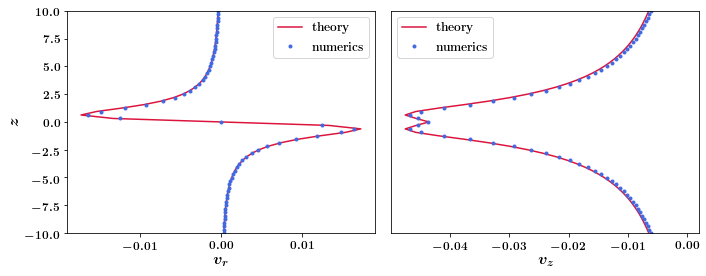

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ind1 = 145
ind2 = 145

plt.subplot(121)
plt.plot(vr_theory[ind1, ind2, :] - np.nanmean(vr_theory), fft_xs, color='crimson', label=r'\textbf{theory}')
plt.plot(vr[ind1, ind2, :] - np.nanmean(vr), fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
plt.ylim(-10, 10)
plt.ylabel(r'\textbf{$z$}',fontsize=16)
plt.xlabel(r'\textbf{$v_r$}',fontsize=16)
plt.xticks([-0.01, 0, 0.01])
plt.legend()

plt.subplot(122)
plt.plot(vz_theory[ind1, ind2, :] - np.nanmean(vz_theory), fft_xs, color='crimson', label=r'\textbf{theory}')
plt.plot(v[2][ind1, ind2, :] - np.nanmean(v[2]), fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
plt.ylim(-10, 10)
#plt.ylabel(r'\textbf{$z$}',fontsize=16)
plt.yticks([])
plt.xlabel(r'\textbf{$v_z$}',fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()

## example: Stokeslet with perturbative odd shear viscosities, $\eta_1^o = -2\eta_2^o$

In [9]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
etaeQ1, etaoQ1 = 0, 0
etaeQ2, etaoQ2 = 0, 0
etaeQ3, etaoQ3 = 0, 0
etaeA, etaoA = 0, 0
etaeS, etaoS = 0, 0
xi = 0
etao1, etao2 = -0.2, 0.1
mu = 1

visc_coeff_list = [etaR1, etaR2, etaRo, etaeQ1, etaoQ1, etaeQ2, etaoQ2, etaeQ3, etaoQ3, etaeA,
                  etaoA, etaeS, etaoS, xi, etao1, etao2, mu]

fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vr = (v[0]*x + v[1]*y) / np.sqrt(x**2+ y**2)
vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


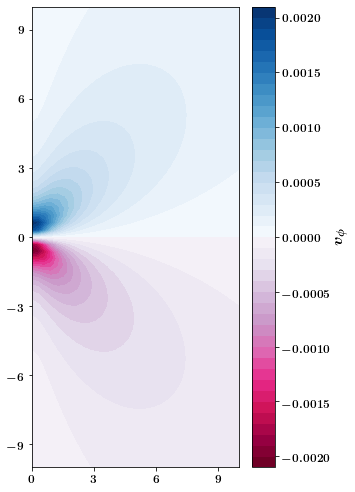

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 7))

plt.subplot(111)

ind = 145
cont = plt.contourf(fft_xs, fft_xs, np.transpose(vphi[ind,:,:]), 50, cmap=newcmp)#, vmin = -1, vmax = 1)
circle = mpatches.Circle([0, 0], radius = 1, color = 'white')
axes.add_patch(circle)

plt.xlim(0, 10)
plt.ylim(-10, 10)
plt.xticks([0, 3, 6, 9], size=12)
plt.yticks([-9, -6, -3, 0, 3, 6, 9], size=12)
#plt.text(0.5, 8.5, coeff_label_list[count], fontsize=16)

cb = plt.colorbar(cont)#, ticks = np.arange(-2, 2.5, 0.5))
cb.set_label(label=r'\textbf{$v_{\phi}$}', size=16)
cb.ax.tick_params(labelsize=12) 

plt.tight_layout()
plt.show()

## example: theory and numerics comparison for Stokeslet with odd viscosity

In [11]:
eps = 0.00001 #add epsilon^2 to denominator of integrand to regularize at q = 0
dq = 0.07 #spacing in Fourier space
Q = 10 #max value of q

F = np.array([0, 0, 1]) #external force

#values of viscosity coefficients
etaR1, etaR2, etaRo = 0, 0, 0
etaeQ1, etaoQ1 = 0, 0
etaeQ2, etaoQ2 = 0, 0
etaeQ3, etaoQ3 = 0, 0
etaeA, etaoA = 0, 0
etaeS, etaoS = 0, 0
xi = 0
etao1, etao2 = 0, 0
mu = 1

vphi_list = []

for i in range(3):
    eta_o_list = [0, 0, 0]
    eta_o_list[i] = 0.01
    etao1, etao2, etaRo = eta_o_list[0], eta_o_list[1], eta_o_list[2]

    visc_coeff_list = [etaR1, etaR2, etaRo, etaeQ1, etaoQ1, etaeQ2, etaoQ2, etaeQ3, etaoQ3, etaeA,
                      etaoA, etaeS, etaoS, xi, etao1, etao2, mu]

    fft_xs, v = v_fourier_ifft(Q, dq, eps, visc_coeff_list, F)

    x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)
    vphi = (-v[0]*y + v[1]*x) / np.sqrt(x**2 + y**2)
    
    vphi_list.append(vphi)

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [12]:
#analytical expression for Stokeslet with shear viscosity mu, force in -z,
#and perturbative odd viscosity for eta_1^o, eta_2^o, eta_R^o
Fz = -F[2]
eps = 0.01
x, y, z = np.meshgrid(fft_xs, fft_xs, fft_xs)

vphi_theory_eta1 = eps*Fz/(32*mu*np.pi) * np.sqrt(x**2 + y**2)*z * (x**2 + y**2 + 4*z**2) / (x**2 + y**2 + z**2)**(5/2)
vphi_theory_eta2 = -eps*Fz/(16*mu*np.pi) * np.sqrt(x**2 + y**2)*z * (x**2 + y**2 - 2*z**2) / (x**2 + y**2 + z**2)**(5/2)
vphi_theory_etaR = eps*Fz/(8*mu*np.pi) * np.sqrt(x**2 + y**2)*z / (x**2 + y**2 + z**2)**(3/2)

vphi_theory_list = [vphi_theory_eta1, vphi_theory_eta2, vphi_theory_etaR]

/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/talikhain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


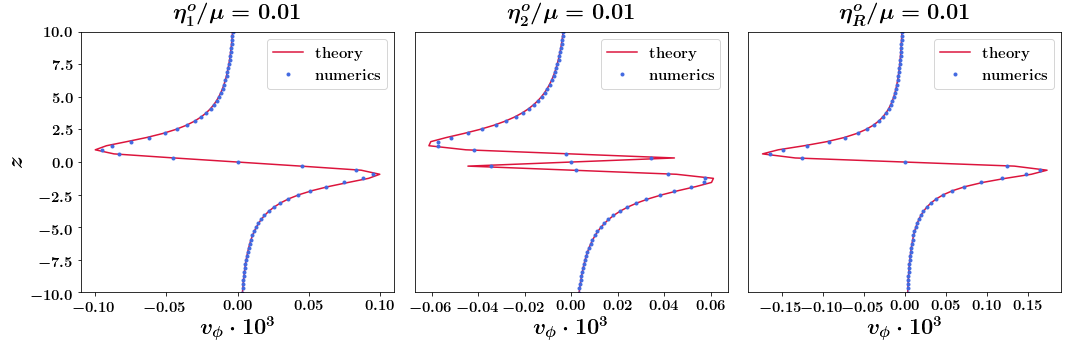

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ind1 = 145
ind2 = 145

title_list = [r'\textbf{$\eta_1^o/\mu = 0.01$}', r'\textbf{$\eta_2^o/\mu = 0.01$}', r'\textbf{$\eta_R^o/\mu = 0.01$}']
for i in range(3):
    
    plt.subplot(1, 3, i+1)
    plt.plot((vphi_theory_list[i][ind1, ind2, :] - np.nanmean(vphi_theory_list[i]))*1e3, fft_xs, color='crimson', label=r'\textbf{theory}')
    plt.plot((vphi_list[i][ind1, ind2, :] - np.nanmean(vphi_list[i]))*1e3, fft_xs, marker='.', linestyle='None', color='royalblue', label=r'\textbf{numerics}')
    plt.ylim(-10, 10)
    if i == 0:
        plt.ylabel(r'\textbf{$z$}',fontsize=22)
    plt.xlabel(r'\textbf{$v_{\phi} \cdot 10^3$}',fontsize=22)
    plt.title(title_list[i], fontsize=22)
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i > 0:
        plt.yticks([])
    
    plt.legend(fontsize=15)

plt.tight_layout()
plt.show()